# Biosignals Processing in Python

Welcome to the course for biosignals processing using NeuroKit and python. You'll find the necessary files to run this example in the [examples](https://github.com/neuropsychology/NeuroKit.py/tree/master/examples/Bio) section.

### Import Necessary Packages

In [7]:
# Import packages
import neurokit as nk
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

# Plotting preferences
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [14.0, 10.0]  # Bigger figures
sns.set_style("whitegrid")  # White background
sns.set_palette(sns.color_palette("colorblind"))  # Better colours

## Block Paradigms

### Preprocessing

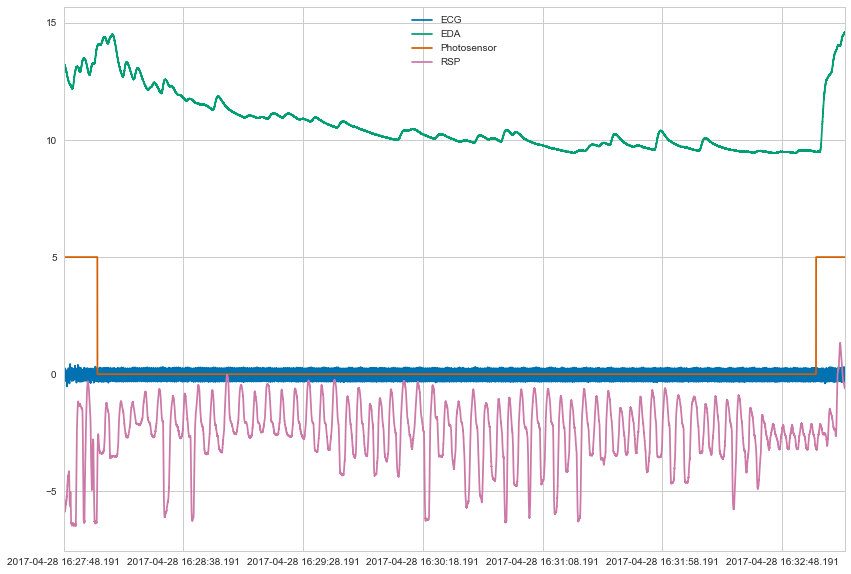

In [8]:
# Download resting-state data
df = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit.py/master/examples/Bio/data/bio_rest.csv", index_col=0)
# Plot it
df.plot()

df contains about 5 minutes of data recorded at 1000Hz. There are 4 channels, EDA, ECG, RSP and the Photosensor used to localize events. In the present case, there is only one event, one sequence of 5 min during which the participant was instructed to to nothing.

First thing that we're gonna do is crop that data according to the photosensor channel, to keep only the sequence of interest.

In [9]:
 # We want to find events on the Photosensor channel, when it goes down (hence, cut is set to lower).
events = nk.find_events(df["Photosensor"], cut="lower") 
print(events)

{'onsets': array([14097]), 'durations': array([300066])}


`find_events` returns a dict containing onsets and durations of each event. Here, it correctly detected only one event. Then, we're gonna crop our data according to that event. The `create_epochs` function returns a list containing epochs of data corresponding to each event. As we have only one event, we're gonna select the `0`th element of that list. 

In [10]:
df = nk.create_epochs(df, events["onsets"], duration=events["durations"], onset=0)
df = df[0]  # Select the first element of that list.

### Processing

Biosignals processing can be done quite easily using `NeuroKit` with the `bio_process` function. Simply provide the corresponding channels and the run the processing. `bio_process` returns a dict containing a dataframe `df`, including raw and processed signals, as well as features relevant to each provided signal.

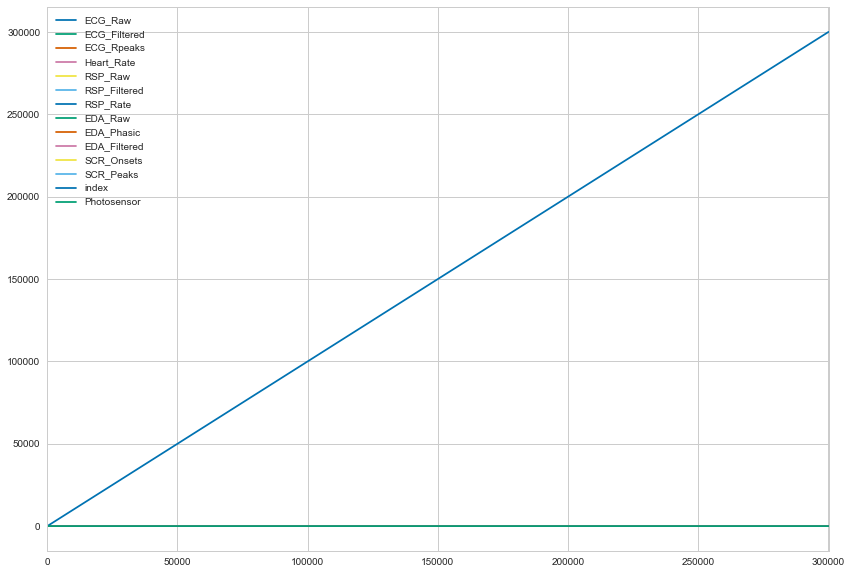

In [11]:
bio = nk.bio_process(ecg=df["ECG"], rsp=df["RSP"], eda=df["EDA"], add=df["Photosensor"])
# Plot the processed dataframe
bio["df"].plot()

### Bio Features Extraction

#### Heart Beats

The processing functions automatically extracts each individual heartbeat, synchronized by their R peak. You can plot all of them.

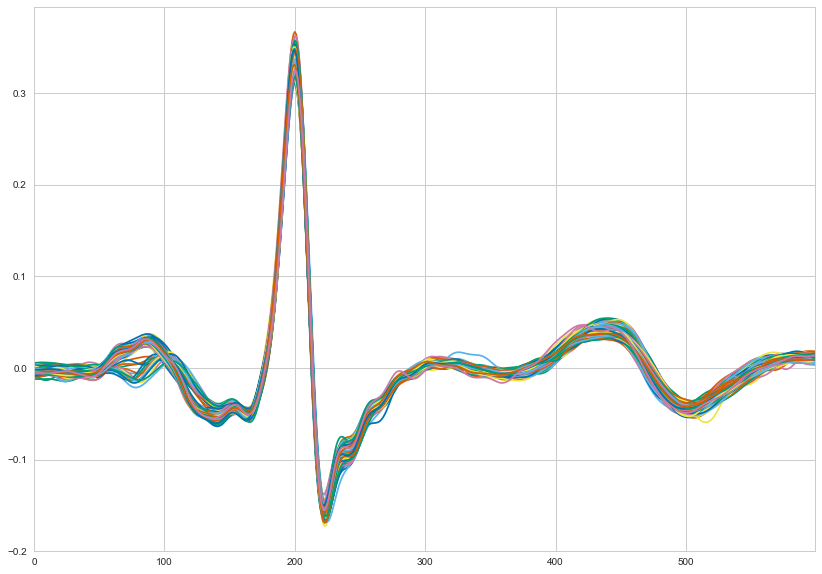

In [6]:
pd.DataFrame(bio["ECG"]["Heart_Beats"]).T.plot(legend=False)  # Plot all the heart beats

### Heart Rate Variability (HRV)

In [7]:
# Print all the HRV indices
bio["ECG_Features"]["ECG_HRV"]

{'HRV_hf': 235.12,
 'HRV_hfnu': 12.27,
 'HRV_lf': 1681.79,
 'HRV_lf_hf': 7.1500000000000004,
 'HRV_lfnu': 87.730000000000004,
 'HRV_mhr': 78.969999999999999,
 'HRV_mrri': 763.14999999999998,
 'HRV_nn50': 13.0,
 'HRV_pnn50': 4.7800000000000002,
 'HRV_rmssd': 24.699999999999999,
 'HRV_sdnn': 50.920000000000002,
 'HRV_total_power': 2280.6799999999998,
 'HRV_vlf': 363.76999999999998}

## Event-Related Analysis

This experiment consisted of 8 events (when the photosensor signal goes down), which were 2 types of images that were shown to the participant: "Negative" vs "Neutral". The following list is the condition order.

In [12]:
condition_list = ["Negative", "Negative", "Neutral", "Neutral", "Neutral", "Negative", "Negative", "Neutral"]

### Find Events

First, we must find events onset within our photosensor's signal using the `find_events()` function. This function requires a treshold and a cut direction (should it select events that are *higher* or *lower* than the treshold).

In [8]:
events = nk.find_events(df["Photosensor"], treshold = 3, cut="lower")
events

{'duration': array([5030, 5030, 5030, 5031, 5031, 5030, 5030, 5031]),
 'onsets': array([ 15905,  37074,  65874,  87457, 110673, 130425, 156113, 186697])}

### Create Epochs

Then, we divise our dataframe in epochs, *i.e.* segments of data around the event. We set our epochs to start at the event start (`onset=0`) and to last for 5000 data points, in our case equal to 5 s (since the signal is sampled at 1000Hz).

In [10]:
epochs = nk.create_epochs(bio["Bio"], events["onsets"], duration=5000, onset=0)

### Create Evoked-Data

We can then itereate through the epochs and store the interesting results in a new dict that will be, at the end, converted to a dataframe.

In [13]:
evoked = {}  # Initialize an empty dict
for epoch in epochs:
    evoked[epoch] = {}  # Initialize an empty dict for the current epoch
    evoked[epoch]["Heart_Rate"] = epochs[epoch]["Heart_Rate"].mean()  # Heart Rate mean
    evoked[epoch]["RSP_Rate"] = epochs[epoch]["RSP_Rate"].mean()  # Respiration Rate mean
    evoked[epoch]["EDA_Filtered"] = epochs[epoch]["EDA_Filtered"].mean()  # EDA mean
    evoked[epoch]["EDA_Max"] = max(epochs[epoch]["EDA_Filtered"])  # Max EDA value
    
    # SRC_Peaks are scored np.nan (NaN values) in the absence of peak. We want to change it to 0
    if np.isnan(epochs[epoch]["SCR_Peaks"].mean()):
        evoked[epoch]["SCR_Peaks"] = 0
    else:
        evoked[epoch]["SCR_Peaks"] = epochs[epoch]["SCR_Peaks"].mean()

evoked = pd.DataFrame.from_dict(evoked, orient="index")  # Convert to a dataframe
evoked["Condition"] = condition_list  # Add the conditions
evoked  # Print

,EDA_Max,Heart_Rate,SCR_Peaks,EDA_Filtered,RSP_Rate,Condition
0,2.904791,76.692448,0.002233,1.119592,9.899207,Negative
1,1.401832,77.758983,0.001362,0.228276,15.088623,Negative
2,0.333022,86.674810,0.000000,0.170198,12.570695,Neutral
3,0.617933,71.802572,0.000000,0.289176,17.845710,Neutral
4,1.120845,72.209853,0.000000,0.700019,15.900692,Neutral
5,2.199279,79.131237,0.001678,1.128347,16.889012,Negative
6,3.707069,80.894028,0.002566,1.398594,17.058186,Negative
7,3.543960,81.304369,0.000000,2.009089,15.289368,Neutral


### Plot Results

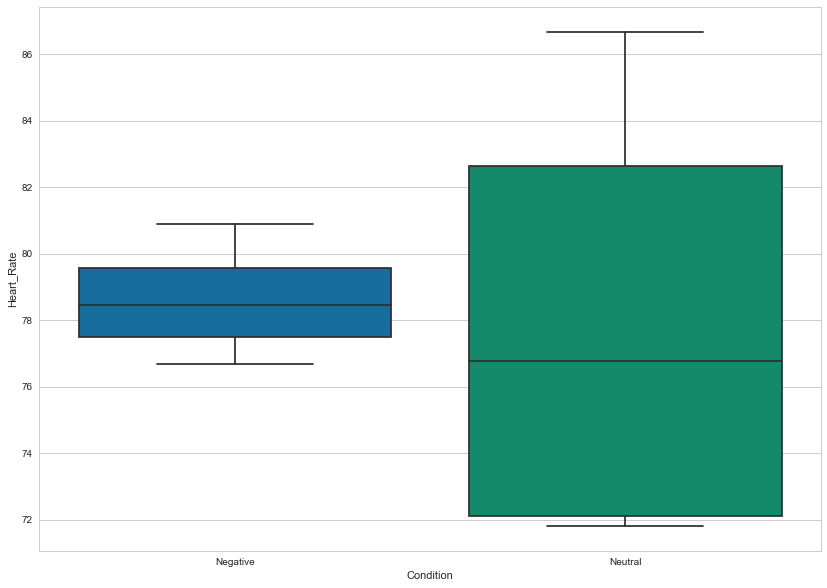

In [14]:
sns.boxplot(x="Condition", y="Heart_Rate", data=evoked)

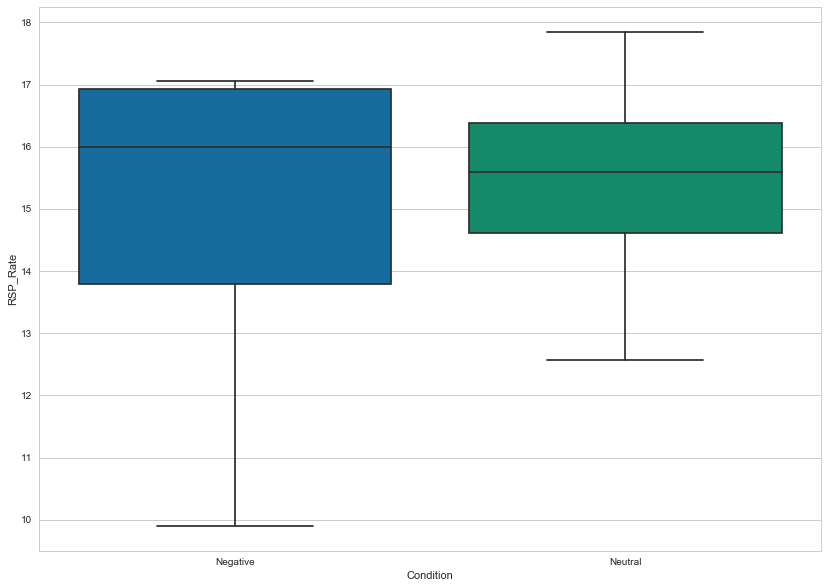

In [15]:
sns.boxplot(x="Condition", y="RSP_Rate", data=evoked)

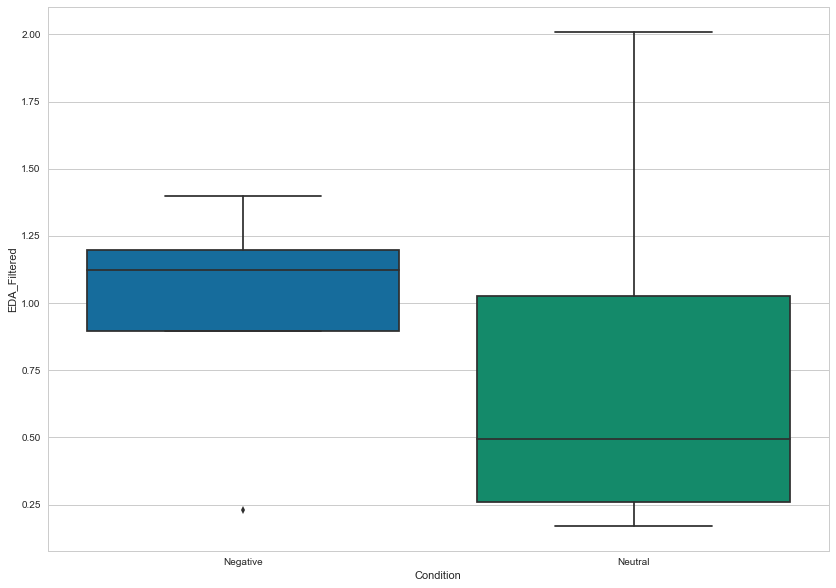

In [16]:
sns.boxplot(x="Condition", y="EDA_Filtered", data=evoked)

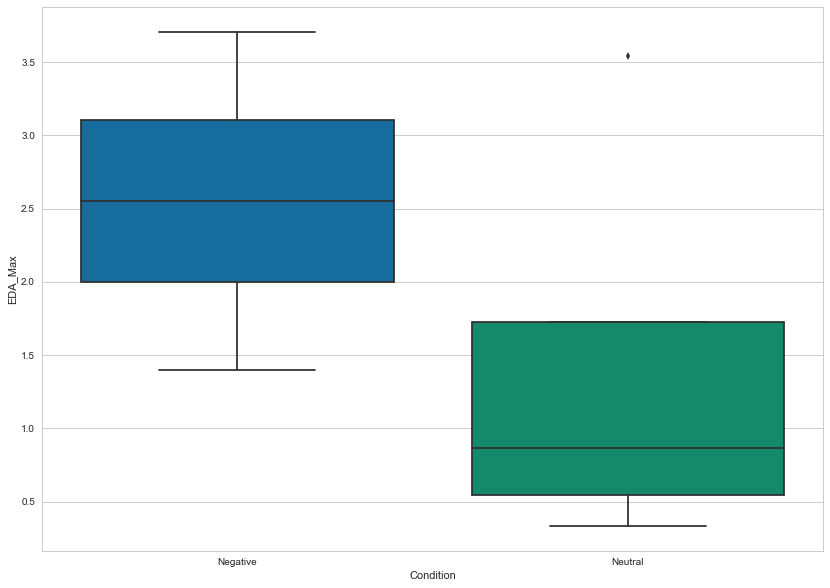

In [17]:
sns.boxplot(x="Condition", y="EDA_Max", data=evoked)

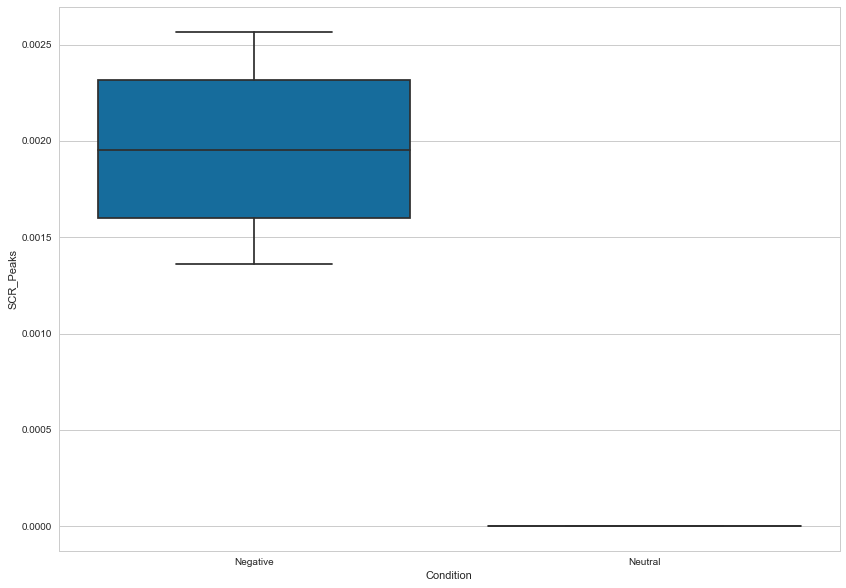

In [18]:
sns.boxplot(x="Condition", y="SCR_Peaks", data=evoked)